In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
import os
import joblib
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

from sklearn.metrics import confusion_matrix, classification_report

# Set directory
base_dir = './sets'
# Load validation set and test set
X_val = np.load(f'{base_dir}/X_val.npy')
y_val = np.load(f'{base_dir}/y_val.npy')
X_test = np.load(f'{base_dir}/X_test.npy')
y_test = np.load(f'{base_dir}/y_test.npy')

# load best sets
over_sampled_best_X_val = np.load(f'{base_dir}/over_sampled_best_X_val.npy')
under_sampled_best_X_val = np.load(f'{base_dir}/under_sampled_best_X_val.npy')
over_sampled_best_X_test = np.load(f'{base_dir}/over_sampled_best_X_test.npy')
under_sampled_best_X_test = np.load(f'{base_dir}/under_sampled_best_X_test.npy')

# make output directory
output_dir = './deeplearning_out'
os.makedirs(output_dir, exist_ok=True)

n_features = X_val.shape[1]
n_best_over_features = over_sampled_best_X_val.shape[1]
n_best_under_features = under_sampled_best_X_val.shape[1]

2024-04-14 19:09:18.368305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 19:09:19.410590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_35528/2105926852.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Tuning Hyperparameters

In [2]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(n_features,)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# UnderSampled Set

Reloading Tuner from ./deeplearning_out/under_no_sel_deepL/tuner0.json
Epoch 1/100


2024-04-14 19:09:20.349581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 19:09:20.543416: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 19:09:20.543743: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 1/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3438 - loss: 2.2713

I0000 00:00:1713118162.689618   35964 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.7426 - loss: 0.9107 - val_accuracy: 0.9571 - val_loss: 0.1604
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9556 - loss: 0.1207 - val_accuracy: 0.9436 - val_loss: 0.1889
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9662 - loss: 0.1040 - val_accuracy: 0.9363 - val_loss: 0.1947
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9575 - loss: 0.0981 - val_accuracy: 0.9484 - val_loss: 0.1551
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9755 - loss: 0.0515 - val_accuracy: 0.9512 - val_loss: 0.1510
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9821 - loss: 0.0523 - val_accuracy: 0.9452 - val_loss: 0.1661
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9871 - loss: 0.0368 - val_accuracy: 0.9448 - val_loss: 0.1651
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9958 - loss: 0.0284 - val_accuracy: 0.9557 - val_

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 3s 867us/step - accuracy: 0.9553 - loss: 0.1418
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 695us/step


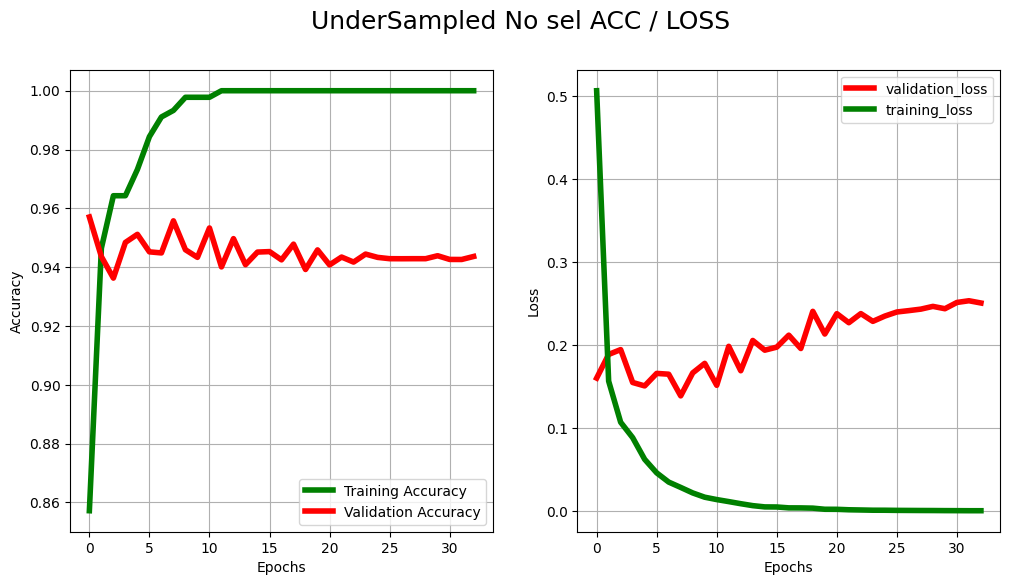

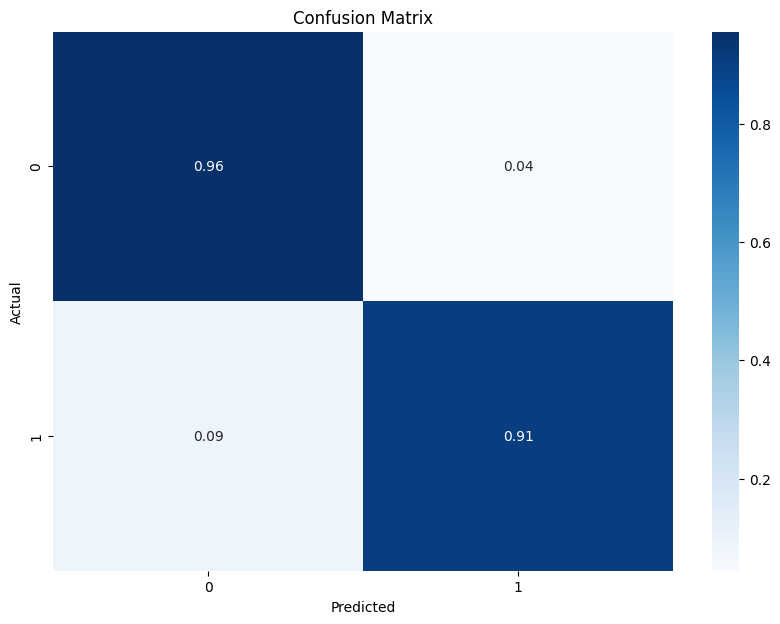

In [3]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_no_sel_deepL'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)


x_train = np.load(f'{base_dir}/under_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_model = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_model)
history = model.fit(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_no_sel', exist_ok=True)

model.save(f'{output_dir}/under_no_sel/model.h5')
with open(f'{output_dir}/under_no_sel/history.json', 'w') as f:
    json.dump(history.history, f)
with open(f'{output_dir}/under_no_sel/best_model.json', 'w') as f:
    json.dump(best_model.values, f)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

with open(f'{output_dir}/under_no_sel/test_results.json', 'w') as f:
    json.dump({'test_loss': test_loss, 'test_acc': test_acc}, f)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Plot of Training and Validation Accuracy/Loss

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', c="green",linewidth=4)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy' ,c="red",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# OverSampled Set

In [4]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(n_features,)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Reloading Tuner from ./deeplearning_out/over_no_sel_deepL/tuner0.json
Epoch 1/100


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9833 - loss: 0.0656 - val_accuracy: 0.9986 - val_loss: 0.0085
Epoch 2/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 964us/step - accuracy: 0.9990 - loss: 0.0054 - val_accuracy: 0.9989 - val_loss: 0.0067
Epoch 3/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 968us/step - accuracy: 0.9994 - loss: 0.0041 - val_accuracy: 0.9992 - val_loss: 0.0062
Epoch 4/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 982us/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9992 - val_loss: 0.0065
Epoch 5/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 963us/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9993 - val_loss: 0.0081
Epoch 6/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9993 - val_loss: 0.0069
Epoch 7/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 973us/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9993 - val_loss: 0.0078
Epoch 8/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 991us/step - accuracy: 0.9997 - loss: 

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9989 - loss: 0.0096
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 3s 792us/step


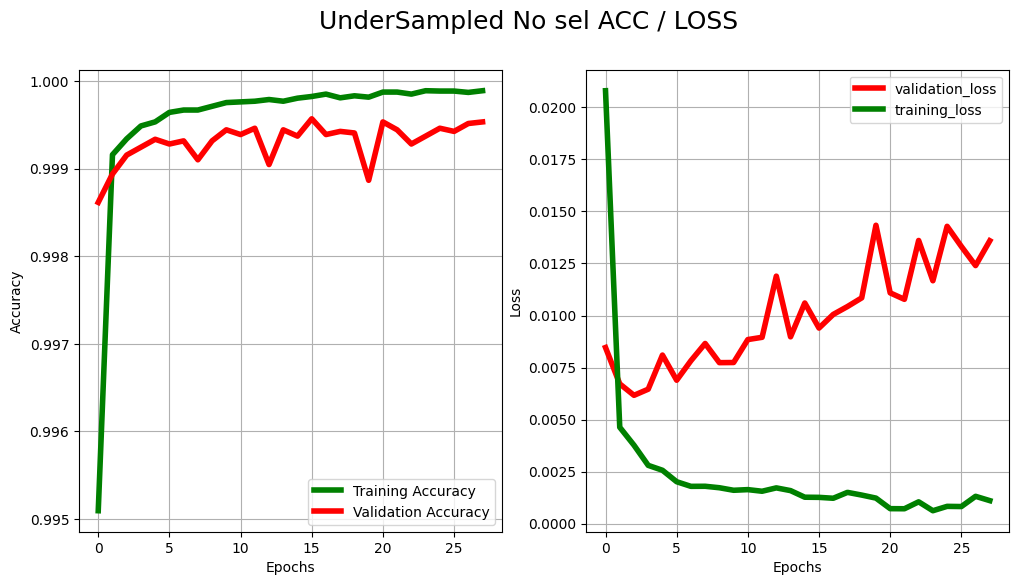

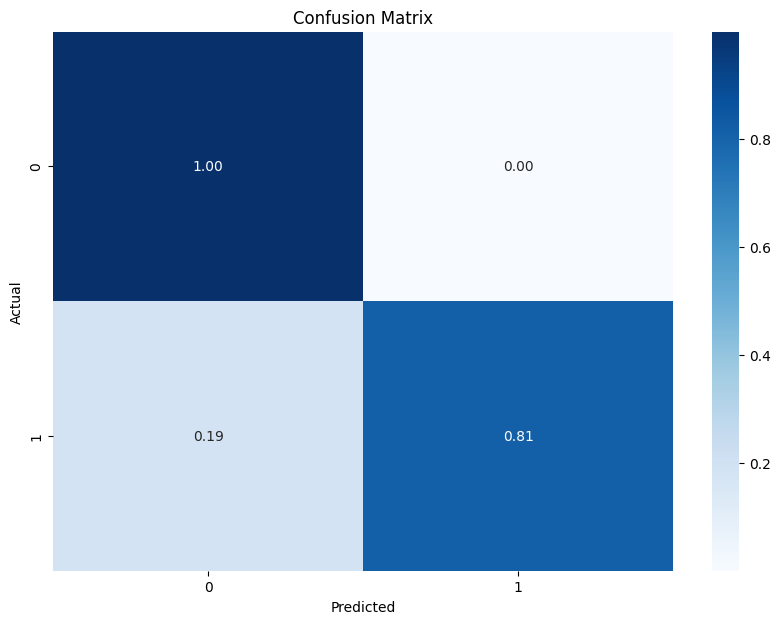

In [5]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_no_sel_deepL'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)


x_train = np.load(f'{base_dir}/over_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_model = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_model)
history = model.fit(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_no_sel', exist_ok=True)

model.save(f'{output_dir}/over_no_sel/model.h5')
with open(f'{output_dir}/over_no_sel/history.json', 'w') as f:
    json.dump(history.history, f)
with open(f'{output_dir}/over_no_sel/best_model.json', 'w') as f:
    json.dump(best_model.values, f)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

with open(f'{output_dir}/over_no_sel/test_results.json', 'w') as f:
    json.dump({'test_loss': test_loss, 'test_acc': test_acc}, f)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Plot of Training and Validation Accuracy/Loss

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', c="green",linewidth=4)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy' ,c="red",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()